In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

train_data = pd.read_json('train.json')
test_data = pd.read_json('test.json')

# 1) Plotting From Data
## Which Cuisines are Most Represented?

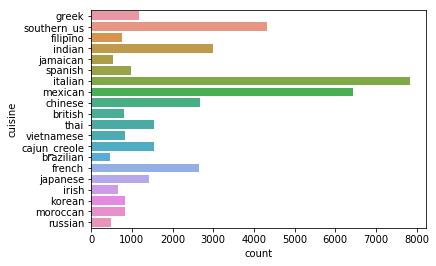

In [4]:
sns.countplot(y = 'cuisine', data=train_data)

## Which Cuisines use the Most Ingredients?

/Users/EdKay/py3env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 30)

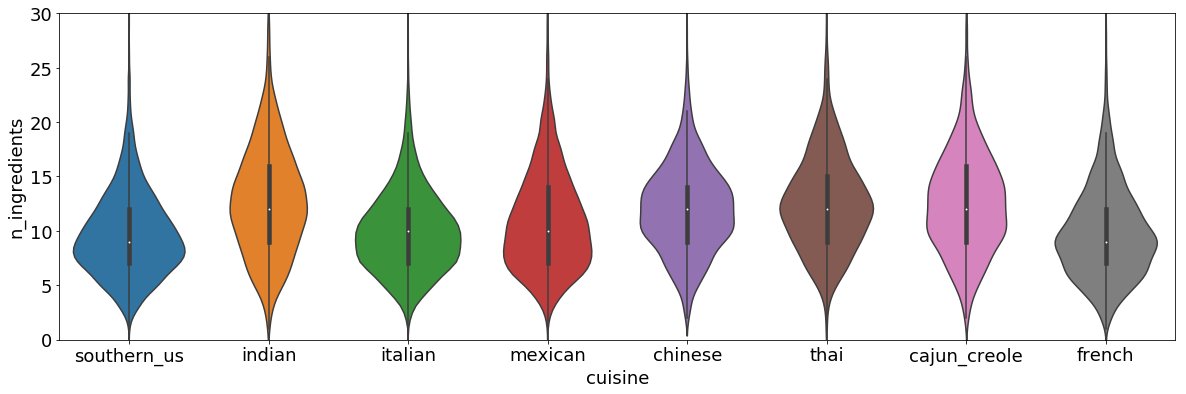

In [5]:
train_data['n_ingredients'] = train_data.ingredients.map(lambda x:len(x))
matplotlib.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(figsize=(20,6))
sns.violinplot(ax = axes,x='cuisine',y='n_ingredients',data=train_data[train_data.cuisine.isin(train_data.cuisine.value_counts().head(8).index)])
axes.set_ylim(0,30)

## One Hot Encoding of List Data to allow further plots and learning
(This step takes a minute or two). Uncomment bits to work with the test data as well

In [6]:
train_ingredients = pd.get_dummies(train_data.ingredients.apply(pd.Series).stack()).sum(level=0)

test_ingredients = pd.get_dummies(test_data.ingredients.apply(pd.Series).stack()).sum(level=0)
#Could also do an inner join to get union of the two
train_ingredients, test_ingredients = train_ingredients.align(test_ingredients,
                                                                   join='left', 
                                                                   axis=1)

test_ingredients = test_ingredients.fillna(0)
train_data_encoded = pd.concat([train_data['cuisine'],train_ingredients],axis = 1)
test_data_encoded = pd.concat([test_data['id'],test_ingredients],axis = 1)

## Plot Most Common Ingredients

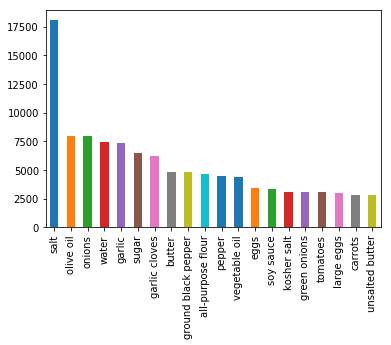

In [7]:
matplotlib.rcParams.update({'font.size': 10})
tempIngredientsPlot = train_data_encoded.drop(['cuisine'],axis=1).sum().sort_values(ascending=False).head(20).plot.bar()

## Plot most Common Ingredients stratified by cuisine

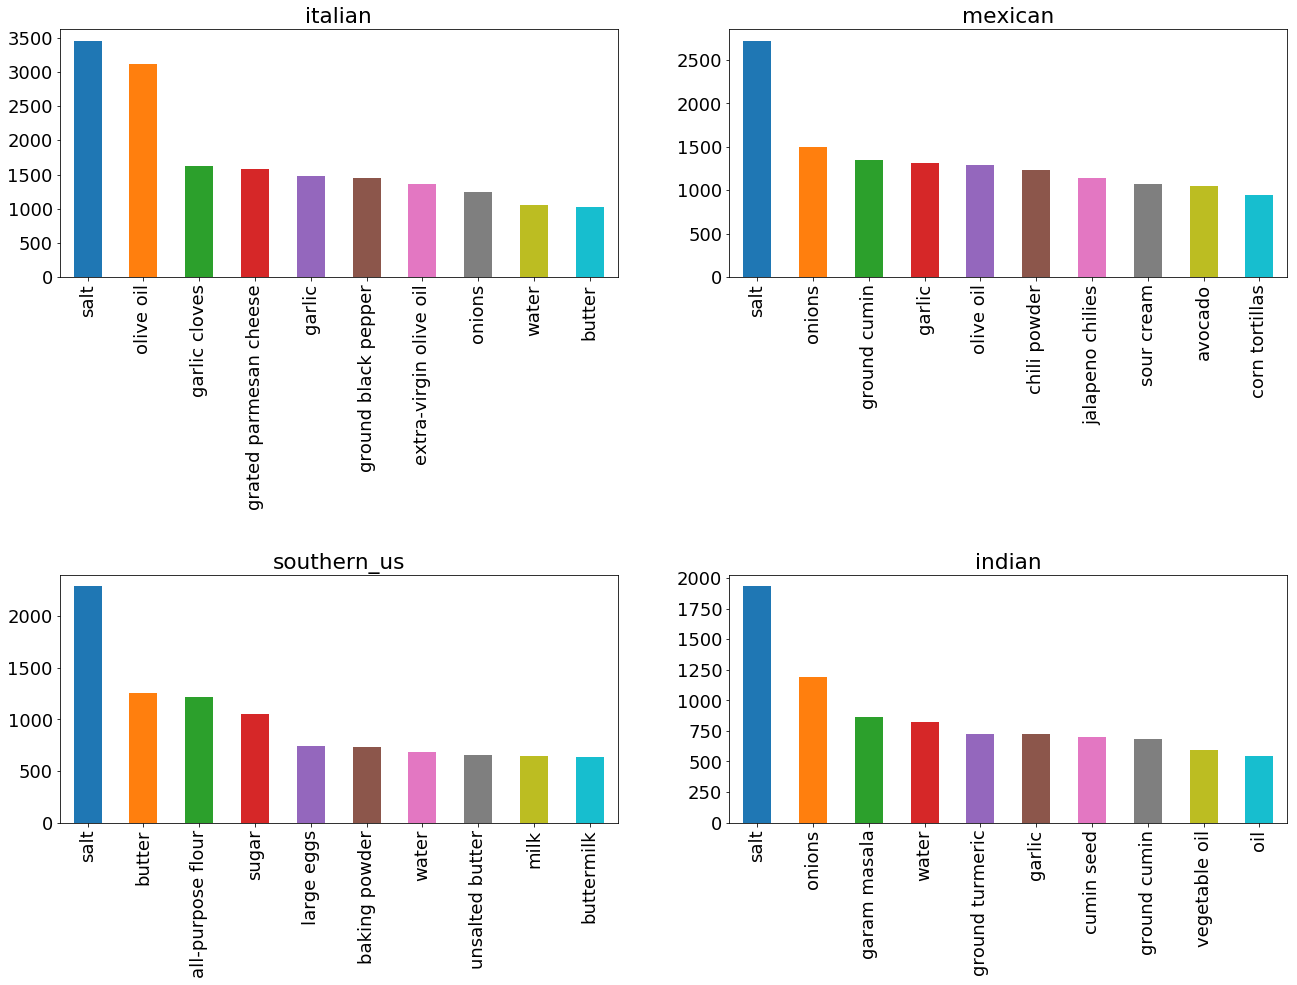

In [8]:
matplotlib.rcParams.update({'font.size': 18})
nRows = 2
nCols = 2
fig, axes = plt.subplots(nRows, nCols)
fig.subplots_adjust(wspace = 0.2,hspace= 1.2,bottom=0.3)
for i in range(nRows):
    for j in range(nCols):
        axes[i,j].set_title(train_data_encoded.cuisine.value_counts().head(nRows*nCols).index[j+(i*nCols)])
        train_data_encoded[train_data_encoded.cuisine == train_data_encoded.cuisine.value_counts().head(nRows*nCols).index[j+(i*nCols)]]\
                                                        .drop(['cuisine'],axis=1)\
                                                        .sum()\
                                                        .sort_values(ascending=False)\
                                                        .head(10)\
                                                        .plot\
                                                        .bar(ax = axes[i,j],figsize=(22,19))
                                

matplotlib.rcParams.update({'font.size': 10})

# 2) Fit Different Models
Define Functions to do hyperparameter tuning and get some detailed results including plotting a confusion matrix

In [9]:
#Function to do parameter tuning
def findBestHyperParameters(pipeline,param_grid,x,y):
    #Just tune based on accuracy and then look at macro averaged precision/recall later to investigate class imbalance
    grid = GridSearchCV(pipeline,param_grid=param_grid,cv=3,scoring = 'accuracy')
    grid.fit(x, y)
    index_best_params = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
    print("CV Results from Best Parameters: ",grid.cv_results_['mean_test_score'][index_best_params])
    return index_best_params, grid.cv_results_

    
#Function to get more detailed results and confusion matrix    
def getConfusionMatrix(pipeline,x,y,title):
    y_predict = cross_val_predict(pipeline, x,y, cv=3)
    
    print('Macro Averaged Precision:',precision_score(y,y_predict,average ='macro'))
    print('Macro Averaged Recall:',recall_score(y,y_predict,average ='macro'))
    print('Macro Averaged F1 Score:',f1_score(y,y_predict,average ='macro'))
    
    cuisine_confusion_matrix = confusion_matrix(y, y_predict,labels=y.unique().tolist())
    confusion_matrix_df = pd.DataFrame(cuisine_confusion_matrix, index = [i for i in y.unique().tolist()],
                  columns = [i for i in y.unique().tolist()])

    plt.figure(figsize = (15,8))
    ax = sns.heatmap(confusion_matrix_df, annot=True, fmt='g',cbar = False)
    ax.set_ylabel('Actual Cuisine')
    ax.set_xlabel('Predicted Cuisine')
    ax.set_title(title)
    
    return confusion_matrix_df


def submitModelTrainedOnAllData(pipeline,x_train,y_train,x_test,x_ids,filename):
    pipeline.fit(x_train, y_train)
    x_test['cuisine'] = pipeline.predict(x_test)
    x_test['id'] = x_ids
    x_test[['id','cuisine']].to_csv(filename,index = False)
    print('Model saved to:', filename)
    
    
    
x_train = train_data_encoded.drop('cuisine',axis =1)
y_train = train_data_encoded.cuisine
x_test = test_data_encoded.drop('id',axis = 1)
y_test_ids = test_data_encoded.id

## Logistic Regression (No class balancing)
First do a grid search for the value of C (determines amount of regularization) and then analyse results using a confusion matrix

Logistic Regression (Unbalanced):
CV Results from Best Parameters:  0.775783174938402
Macro Averaged Precision: 0.7571718605212342
Macro Averaged Recall: 0.6593336706622318
Macro Averaged F1 Score: 0.6985302948421064


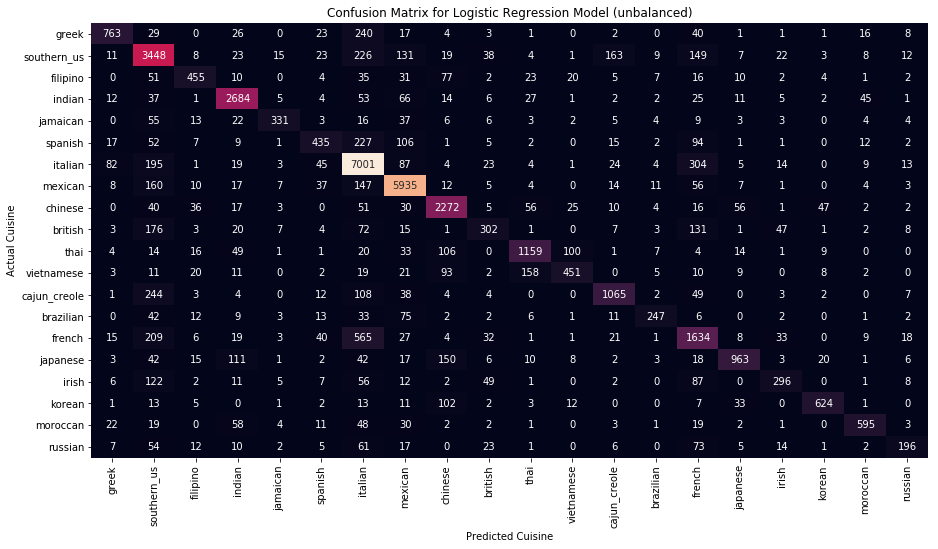

In [10]:
logistic_regression_pipeline_unbalanced = make_pipeline(LogisticRegression(class_weight=None))
#Search for Best Parameters with Grid Search.
param_grid = [
  {'logisticregression__C': [0.5, 1, 5]},
 ]

print("Logistic Regression (Unbalanced):")
index_best_results, cv_results_grid_search_unbalanced = findBestHyperParameters(logistic_regression_pipeline_unbalanced,param_grid,x_train,y_train)

best_logistic_regression_c = cv_results_grid_search_unbalanced['param_logisticregression__C'][index_best_results]
logistic_regression_pipeline_unbalanced_tuned = make_pipeline(LogisticRegression(C=best_logistic_regression_c,class_weight=None))
confusionMatrix_unbalanced = getConfusionMatrix(logistic_regression_pipeline_unbalanced_tuned,x_train,y_train,'Confusion Matrix for Logistic Regression Model (unbalanced)')

#Uncomment below to submit model on test data
#submitModelTrainedOnAllData(logistic_regression_pipeline_unbalanced_tuned,x_train,y_train,x_test,y_test_ids,filename = 'lr_unbalanced.csv')

## Logistic Regression (Class balancing)
It looks like in the previous model there is a lot of prediction of "Italian" regardless of cuisine. We look a the effect of increasing the class weight of the less prevalent classes


Logistic Regression (Balanced):
CV Results from Best Parameters:  0.7623824609041082
Macro Averaged Precision: 0.6692821800651798
Macro Averaged Recall: 0.7026316872128425
Macro Averaged F1 Score: 0.6831491785038144


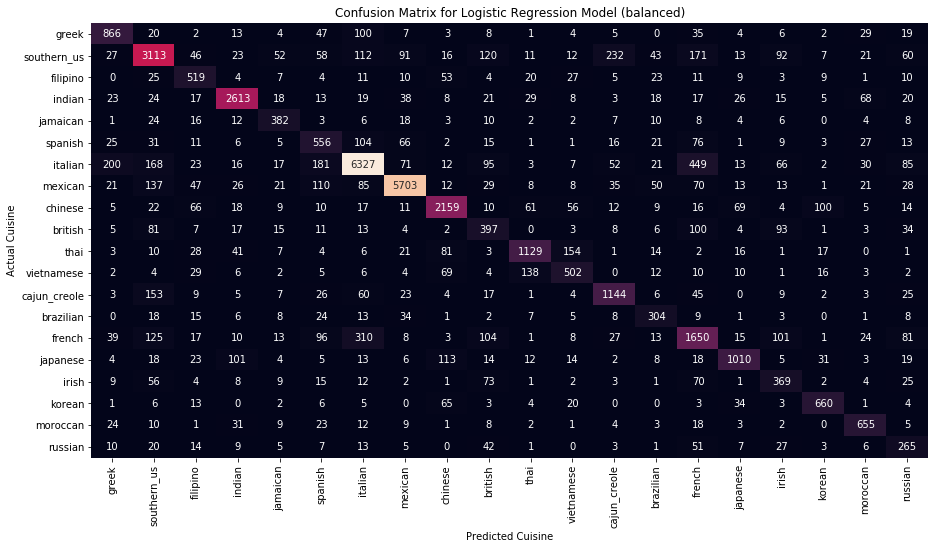

In [11]:
logistic_regression_pipeline_balanced = make_pipeline(LogisticRegression(class_weight='balanced'))

print("Logistic Regression (Balanced):")
index_best_results, cv_results_grid_search_balanced = findBestHyperParameters(logistic_regression_pipeline_balanced,param_grid,x_train,y_train)

best_logistic_regression_c = cv_results_grid_search_balanced['param_logisticregression__C'][index_best_results]
logistic_regression_pipeline_balanced_tuned = make_pipeline(LogisticRegression(C=best_logistic_regression_c,class_weight='balanced'))
confusionMatrix_balanced = getConfusionMatrix(logistic_regression_pipeline_balanced_tuned,x_train,y_train,'Confusion Matrix for Logistic Regression Model (balanced)')

#Uncomment below to submit model on test data
#submitModelTrainedOnAllData(logistic_regression_pipeline_balanced_tuned,x_train,y_train,x_test,y_test_ids,filename = 'lr_balanced.csv')

## Difference in confusion matrix between balanced and unbalanced
Although the above plot makes it look like there are less off diagonal predictions in the prevalent cuisines, we plot the difference between the balanced and unbalanced confusion matrices to see the difference

Text(0.5,1,'Balanced minus Unbalanced Logistic Regression')

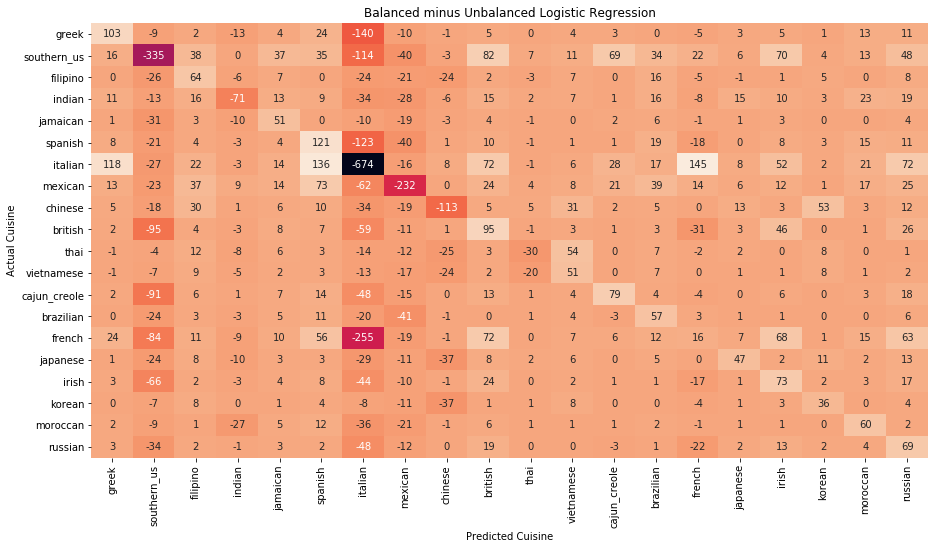

In [12]:
deltaBalancedMinusUnbalanced = confusionMatrix_balanced - confusionMatrix_unbalanced
plt.figure(figsize = (15,8))
ax = sns.heatmap(deltaBalancedMinusUnbalanced, annot=True, fmt='g',cbar = False)
ax.set_ylabel('Actual Cuisine')
ax.set_xlabel('Predicted Cuisine')
ax.set_title('Balanced minus Unbalanced Logistic Regression')

### Conclusions of balancing data
Balancing the data results in
- Fewer predictions of more prevalent classes (italian, indian, southern_us, mexican)
- More predictions of less prevalent classes
- Lower accuracy score (as expected as this takes into account class prevalence)
- Lower macro-average precision (it appears that you end up picking up more false positives overall)
- Higher macro-average recall (makes sense as you end up picking up more of the minority classes)
- Lower macro-average f1 score

It appears that on this dataset that overall it is not worth balancing the classes for a logistic regression classifier


## Random Forest
NB the data is so high dimensional that having anything other than linear decision boundaries will add unecessary complciations and probably give worse accuracy. We will try and random forest as it doesn't require much parameter tuning so we can check its accuracy fairly quickly.

In [13]:
random_forest_pipeline = make_pipeline(RandomForestClassifier())
#Search for Best Parameters with Grid Search
param_grid = [
  {'randomforestclassifier__n_estimators': [5, 10, 20]},
 ]


print("Random Forest (Unbalanced):")
index_best_results, cv_results_grid_search_unbalanced = findBestHyperParameters(random_forest_pipeline,param_grid,x_train,y_train)

Random Forest (Unbalanced):
CV Results from Best Parameters:  0.6857997686931161


The accuracy is significantly lower than in logistic regression

# Potential Extensions

## Different Encoding of Text
Reduce Natural Variation in words by Lemmatizing (e.g. changes eggs to egg, and walk/walked/walks/walking to walk) and then using a Term Frequency - Inverse Document Frequency transform. This is common in text recognition and tells you how often a term comes up in a document weighted by the frequency of that term in other documents

## Different Classifiers
I have also tried a linear SVM but this takes a very long time due to the high dimensionality of the input data. Given the input data is so high dimensional, extending to a more complicated classifier beyond logistic regression is unlikely to have much impact (see random forest 